In [2]:
import pandas as pd

In [3]:
print("Pandas version:", pd.__version__)

Pandas version: 2.3.3


In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
import squidpy as sq

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None t

squidpy==1.6.5


python(50648) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 380M/380M [01:20<00:00, 4.96MB/s] 
100%|██████████| 314M/314M [01:05<00:00, 5.05MB/s] 


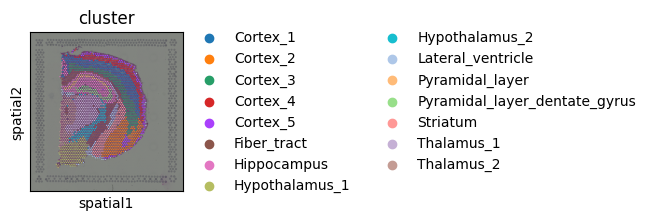

In [3]:
sq.pl.spatial_scatter(adata, color="cluster")

In [4]:
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f],
    axis="columns",
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(
    adata.obsm["features"].columns
)

  0%|          | 0/2688 [00:00<?, ?/s]python(51077) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51079) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51080) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51081) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51082) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51083) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/m

/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/opt/miniconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():
/var/folders/_0/j8xw5t8j6p3dg7_fq82t36gr0000gp/T/ipykernel_50139/3320298302.py:18: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


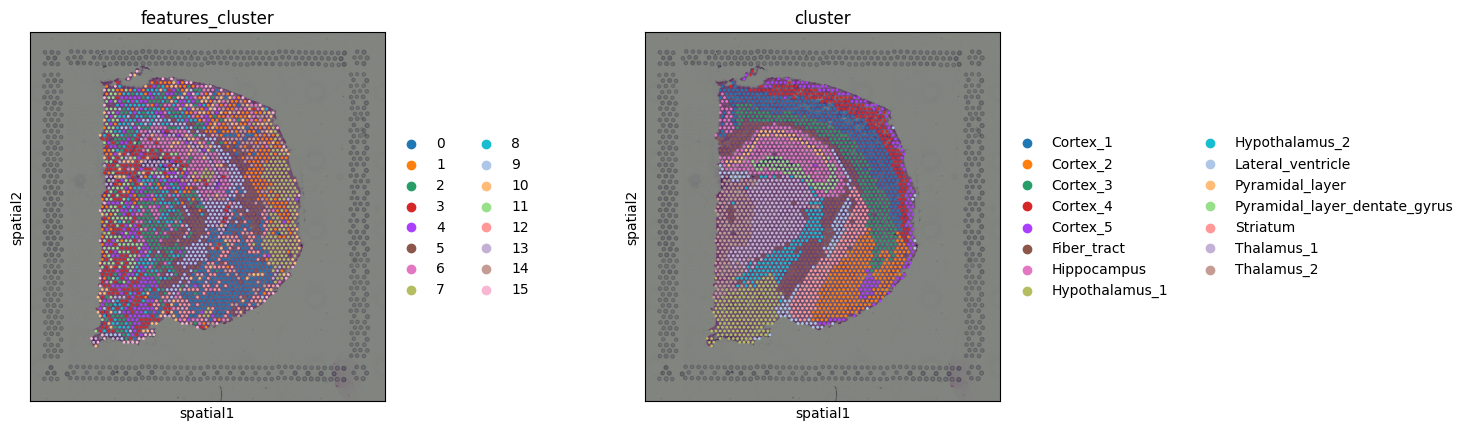

In [7]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sq.pl.spatial_scatter(adata, color=["features_cluster", "cluster"])